# Single-Shot CNN Denoising

We demonstrate that a deep neural net can be trained to denoise a _single_ noisy image, taking advantage of the fact that one 512 x 512 image contains ~250,000 dimensions of information.

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [3]:
import sys
sys.path.append("..")


In [4]:
from util import show, plot_images, plot_tensors

c:\Users\ADMIN\anaconda3\envs\0726_noise2self\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import disk
from skimage.filters import gaussian, median
from skimage import data, img_as_float, img_as_ubyte
from skimage.color import gray2rgb
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio as psnr


from skimage.io import imread, imshow_collection
from skimage import data
import matplotlib.pyplot as plt
%matplotlib inline


In [6]:
plt.rc('figure', figsize = (5,5))

(733, 733)


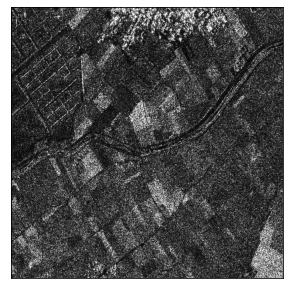

In [7]:
import cv2
from PIL import Image
import os 
#path = "D:/noise2self-master/noise2self-master/sar_data"
# 이미지 읽기
img_gray = cv2.imread(os.path.join(r'C:\Users\ADMIN\Desktop\SAR_image\noise2self\noise2self-master\sar_data', 'noisy_sample.png'))

# 컬러 이미지를 그레이스케일로 변환
img_cv_gray = cv2.cvtColor(img_gray, cv2.COLOR_BGR2GRAY)
show(img_cv_gray)
print(img_cv_gray.shape)

# 이미지 저장
#cv2.imwrite(path, img_cv_gray)
#cv2.imwrite("D:/noise2self-master/noise2self-master/ddiirr", img_cv_gray)
# 이미지 사이즈 변경
# img_gray_resize = cv2.resize(img_cv_gray, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)  # 가로, 세로 모두 반으로 줄이기
# img_gray_reduced = cv2.resize(img_cv_gray, None, interpolation=cv2.INTER_AREA)

# 이미지 화면으로 보기
# cv2.imshow('color', img_gray)  # color라는 이름의 윈도우 안에 img_gray 이미지 보여주기
# cv2.imshow('gray-scale', img_gray_resize)
# cv2.imshow('gray-scale reduced', img_gray_reduced)



(800, 800)


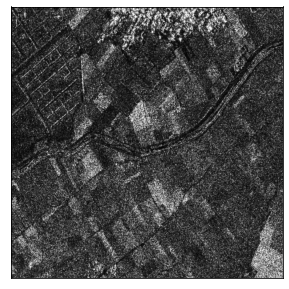

In [8]:

from skimage.transform import resize
img_resize = resize(img_cv_gray, (800,800))
show(img_resize)
print(img_resize.shape)
noisy_image= img_resize

In [9]:
# show(noisy_image)
# print(noisy_image.shape)

In [10]:
# 가우시안 노이즈 입히기 
# np.random.seed(3)
# noisy_image = random_noise(img_resize, mode = 'gaussian', var=5)
# show(noisy_image)
# print(noisy_image.shape)

In [11]:
# gpu 설정하기 
# from util import getbestgpu
# device = getbestgpu()

# Masking

The strategy is to train a $J$-invariant version of a neural net by replacing a grid of pixels with the average of their neighbors, then only evaluating the model on the masked pixels.

In [12]:
import torch
noisy = torch.Tensor(noisy_image[np.newaxis, np.newaxis])
# noisy_image = cv2.normalize(img_resize, None, 0, 255, cv2.NORM_MINMAX)
from mask import Masker
masker = Masker(width = 4, mode='interpolate')

In [36]:
t = np.array([0.5]*640000)

In [37]:
ft = torch.FloatTensor(t)

In [41]:
ft = ft.view(noisy.shape)

In [43]:
test_noisy = noisy - ft

In [49]:
noisy = test_noisy

In [47]:
type(test_noisy)

torch.Tensor

In [48]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() 
scaler.fit(test_noisy)
norm_rs = scaler.transform(test_noisy)

ValueError: Found array with dim 4. MinMaxScaler expected <= 2.

# Model

For our model, we use a deep convolutional network.

In [13]:
# layers 설정하기
torch.manual_seed(3)
from models.dncnn import DnCNN
model = DnCNN(1, num_of_layers = 7)

In [14]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

186112

In [15]:
noisy_image.ravel().shape


(640000,)

# Training

In [16]:
from torch.nn import MSELoss, L1Loss
from torch.optim import Adam

loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.01)
epochs= 1000

In [17]:
# gpu 설정하기
# model = model.to(device)
# noisy = noisy.to(device)

In [50]:
losses = []
val_losses = []
best_images = []
best_val_loss = 1

for i in range(epochs):
    model.train()
    
    net_input, mask = masker.mask(noisy, i % (masker.n_masks - 1))
    net_output = model(net_input)
    
    loss = loss_function(net_output*mask, noisy*mask)
    optimizer.zero_grad()
 
    loss.backward()
    
    optimizer.step()
    
    if i % 10 == 0:
        losses.append(loss.item())
        model.eval()
        
        net_input, mask = masker.mask(noisy, masker.n_masks - 1)
        net_output = model(net_input)
    
        val_loss = loss_function(net_output*mask, noisy*mask)
        
        val_losses.append(val_loss.item())
        
        print("(", i, ") Loss: \t", round(loss.item(), 5), "\tVal Loss: \t", round(val_loss.item(), 5))

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            denoised = np.clip(model(noisy).detach().cpu().numpy()[0, 0], 0, 1).astype(np.float64)
            best_psnr = psnr(denoised, noisy_image)
            best_images.append(denoised)
            print("\tModel PSNR: ", np.round(best_psnr, 2))

( 0 ) Loss: 	 0.01403 	Val Loss: 	 0.01338
	Model PSNR:  12.12
( 10 ) Loss: 	 0.00164 	Val Loss: 	 0.00239
	Model PSNR:  10.08
( 20 ) Loss: 	 0.00145 	Val Loss: 	 0.00154
	Model PSNR:  10.13
( 30 ) Loss: 	 0.00142 	Val Loss: 	 0.00158
( 40 ) Loss: 	 0.00131 	Val Loss: 	 0.00131
	Model PSNR:  10.22
( 50 ) Loss: 	 0.00128 	Val Loss: 	 0.0013
	Model PSNR:  10.36
( 60 ) Loss: 	 0.00129 	Val Loss: 	 0.00129
	Model PSNR:  10.34
( 70 ) Loss: 	 0.00124 	Val Loss: 	 0.00126
	Model PSNR:  10.36
( 80 ) Loss: 	 0.00121 	Val Loss: 	 0.00124
	Model PSNR:  10.38
( 90 ) Loss: 	 0.00124 	Val Loss: 	 0.00123
	Model PSNR:  10.37


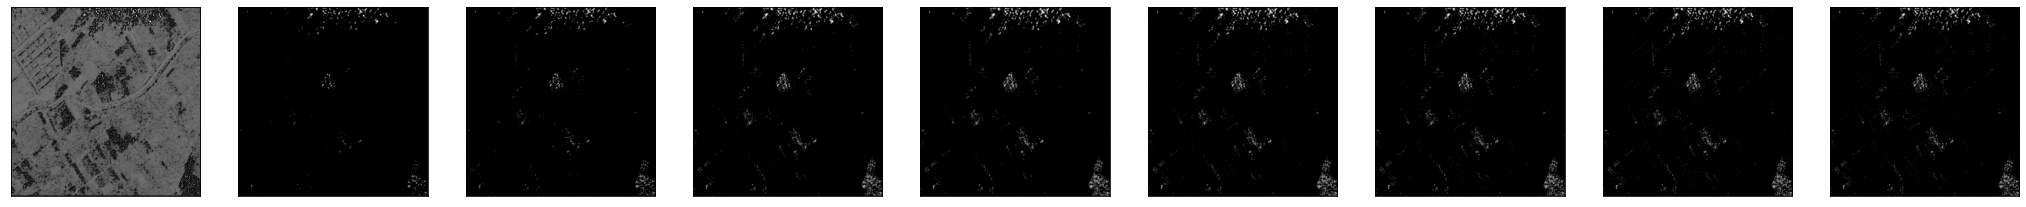

In [51]:
import os 
# path = r"D:\noise2void-master\SAR\result\learingrates=0.01\epochs=5000".replace('\\', '/', 10)
plot_images(best_images[::1])
plt.savefig(os.path.join(r'C:\Users\ADMIN\Desktop\SAR_image\noise2self\noise2self-master\sar_data', 'plot_images2'))


In [ ]:
denoised = best_images[-1]

In [ ]:
 psnr(denoised, noisy_image)

In [ ]:
inset_x_min = 10
inset_x_max = 170
inset_y_min = 90
inset_y_max = 220

get_inset = lambda x: x[inset_x_min:inset_x_max, inset_y_min:inset_y_max]

In [ ]:
show(get_inset(denoised))
plt.savefig(f'{path}/enlarge')

In [ ]:
inset_x_min = 0
inset_x_max = 800
inset_y_min = 0
inset_y_max = 800

get_inset = lambda x: x[inset_x_min:inset_x_max, inset_y_min:inset_y_max]

In [ ]:
show(get_inset(denoised))
plt.savefig(f'{path}/best')